---

# **Proyecto: Alcanzando los objetivos de desarrollo sostenible**

---
**Autor:**

* Andrés Felipe Flórez Olivera
---


Este proyecto utiliza técnicas de NLP y machine learning para clasificar textos automáticamente según los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, adoptada en 2015. 

Esta agenda busca reducir la pobreza, mejorar el acceso a salud y educación, promover la igualdad de género y minimizar el impacto ambiental, entre otros fines. 

El proyecto surge ante la necesidad de analizar grandes volúmenes de información textual de fuentes participativas, una tarea que tradicionalmente requiere mucho tiempo y expertos para relacionar los textos con los ODS. 

La solución propuesta facilita la toma de decisiones informadas para políticas públicas, usando el conjunto de datos “OSDG Community Dataset” (2023), que incluye 40,067 textos, 3,000 de ellos de fuentes de la ONU, traducidos al español y aumentados con herramientas como DeepL y ChatGPT. 

El objetivo es ofrecer una herramienta clara y accesible para evaluar y alinear políticas con los ODS, apoyando entidades como el UNFPA en el seguimiento y evaluación del desarrollo sostenible.

In [ ]:
import pandas as pd
import numpy as np
import scipy
import gensim
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [15]:
# Lectura de archivos en excel
file_path = "datos.xlsx"
df_raw = pd.read_excel(file_path, engine='openpyxl')

# Chequeo básico
print(df_raw.head())

                          doi                           text_id  \
0  10.6027/9789289342698-7-en  00021941702cd84171ff33962197ca1f   
1        10.18356/eca72908-en  00028349a7f9b2485ff344ae44ccfd6b   
2  10.1787/9789264289062-4-en  0004eb64f96e1620cd852603d9cbe4d4   
3     10.1787/5k9b7bn5qzvd-en  0006a887475ccfa5a7f5f51d4ac83d02   
4  10.1787/9789264258211-6-en  0006d6e7593776abbdf4a6f985ea6d95   

                                                text  \
0  From a gender perspective, Paulgaard points ou...   
1  Labour legislation regulates maximum working h...   
2  The average figure also masks large difference...   
3  The extent to which they are akin to corruptio...   
4  A region reporting a higher rate will not earn...   

   ObjetivosDesarrolloSostenible  labels_negative  labels_positive  \
0                              5                1                8   
1                             11                2                1   
2                              3                1 

# **Preparación de los datos**


Una vez cargados los datos a partir del formato excel, eliminamos las columnas irrelecantes como `doi` y el  `text_id`. Por otra parte, separamos los textos y la etiqueta de los mísmos respectivamente en las variables `X` y `y`. Además, cargamos las stopwords a partir de la librería `nltk` necesarias para el preprocesamiento adecuado de los textos, pero se chequea previamente por si estos han sido ya descargados anteriormente.

In [16]:
# Eliminar columnas innecesarias
df = df_raw.drop(['doi', 'text_id'], axis=1, inplace=False)

# Definicion de la columna que contiene los textos y definicion de la variable objetivo

X = df['text']
y = df['ObjetivosDesarrolloSostenible']

# Descargar stopwords solo si es necesario
try:
    stop_words = stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')
    stop_words = stopwords.words('spanish')

# Mostrar la cantidad de datos
print(f"Cantidad de datos = {X.shape[0]}")

Cantidad de datos = 32217


In [17]:
# Revisamos si hay valores duplicados
print("Cantidad de valores duplicados =", X.duplicated().sum())

Cantidad de valores duplicados = 0


In [18]:
# Revisamos si hay valores nulos
print("Cantitad de valores nulos = ", X.isna().sum())

Cantitad de valores nulos =  0


---
**PIPELINE DE PREPROCESAMIENTO**

---

En este microproyecto, emplearemos dos enfoques para generar representaciones numéricas de los textos que serán procesados y clasificados: el mecanismo Bag of Words y el modelo de vectorización de palabras Word2Vec.

### **Mecanismo de Bag of Words (BoW)**

El modelo BoW es una técnica clásica en el procesamiento de lenguaje natural (NLP) que convierte texto en representaciones numéricas para algoritmos de aprendizaje automático. Este enfoque simplifica el texto a una colección de palabras, ignorando la gramática y el orden, y representa cada documento como un vector en un espacio de alta dimensión, donde cada dimensión corresponde a una palabra del vocabulario. Las columnas de la matriz indican la presencia (binaria) o la frecuencia (no binaria) de las palabras, mientras que las filas representan cada texto.

#### **Construcción del Modelo BoW**

1. **Tokenización:** El texto se divide en palabras, eliminando puntuaciones, espacios en blanco y stopwords, y convirtiéndolo a minúsculas.
   
2. **Creación del Vocabulario:** Se genera una lista de palabras únicas presentes en el corpus, formando el vocabulario.

3. **Vectorización:** Cada documento se convierte en un vector que cuenta la frecuencia de cada palabra en el vocabulario, resultando en un vector disperso, ya que no todas las palabras del vocabulario están presentes en todos los documentos.

Aunque es eficaz para capturar la frecuencia de palabras, BoW no toma en cuenta el contexto ni las relaciones semánticas entre palabras, lo que puede llevar a interpretaciones incorrectas en tareas de clasificación.

Utilizamos `RegexTokenizer()` con la expresión regular `\w+` para conservar solo las palabras. Los pasos del método `text_preprocessor` incluyen:

* Tokenización de palabras, descartando espacios vacíos.
* Acumulación de tokens que no son stopwords.
* Uso de `PorterStemmer` para realizar el stemming.
* Reconstrucción de la frase preprocesada para la vectorización.

Para generar las representaciones numéricas, empleamos dos opciones:

* **Modelo Bag of Words:** Implementado mediante el método `bag_of_words` con `CountVectorizer`.
* **Word2Vec:** Implementado mediante el método `text2vec` utilizando `Word2Vec`.


In [19]:
# Pipeline de preprocesamiento de texto

class TextPreprocessor:
    def __init__(self, text_model='bow', vec_size=100, window=5, min_count=1, sg=1):
        self.vec_size = vec_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.text_model = text_model

    # Preprocesamiento
    def preprocess_text(self, text, show_tokens=False):
        tokenizer = RegexpTokenizer(r'\w+')
        stemmer = PorterStemmer()
        tokens = tokenizer.tokenize(text)
        tokens = [word.lower() for word in tokens if word not in stopwords.words('english')]
        tokens = [stemmer.stem(word) for word in tokens]

        if show_tokens:
            return tokens
        else:
            return ' '.join(tokens)

    # BoW
    def bag_of_words(self):
        bow = CountVectorizer(preprocessor=self.preprocess_text)
        return bow

    # Word2Vec
    def text2vec(self, preprocessed_texts):
        model = Word2Vec(sentences=preprocessed_texts, vector_size=self.vec_size,
                         window=self.window, min_count=self.min_count, sg=self.sg)
        model.save("word2vec.model")
        vectors = [[model.wv[word] for word in sentence if word in model.wv] for sentence in preprocessed_texts]

        if len(vectors) == 0:
            return np.zeros(self.vec_size)
        sentence_vectors = [np.mean(vector, axis=0) for vector in vectors if len(vector) > 0]
        return np.array(sentence_vectors)

    # Procesamiento de texto
    def text_processing(self, X):
        if self.text_model == "bow":
            steps = [('vectorizer', self.bag_of_words()), ('tfidf', TfidfTransformer())]
            pipe = Pipeline(steps)
            return pipe.fit_transform(X)

        elif self.text_model == 'word2vec':

            preprocessed_texts = [self.preprocess_text(text, show_tokens=True) for text in X]
            
            # Word2Vec
            sentence_vectors = self.text2vec(preprocessed_texts)
            return sentence_vectors
        else:
            raise ValueError('Error')

Luego, observemos que el método `preprocess_text()` genera un proceso de tokenización y steamming adecuado.

In [20]:
# Tokenización y Stemming por medio del constructor generado
text_processor = TextPreprocessor()
import random

# Selecciona una frase aleatoria de X
frase_random = random.choice(X)

# Procesa la frase aleatoria
frase_tokenizada_procesada = text_processor.preprocess_text(frase_random, show_tokens=True)
frase_completa_procesada = text_processor.preprocess_text(frase_random, show_tokens=False)

print('Frase de ejemplo sin tokenizar:')
print()
print(frase_completa_procesada)
print()
print('Frase de ejemplo tokenizada:')
print()
print(frase_tokenizada_procesada)

Frase de ejemplo sin tokenizar:

they may also deleg without payment person outsid famili provid formal institut the paid unpaid deleg caregiv person institut mean work effort involv simpli replac elimin if qualiti servic relat infrastructur exampl transport infrastructur standard task may take longer difficult complet owe distanc involv

Frase de ejemplo tokenizada:

['they', 'may', 'also', 'deleg', 'without', 'payment', 'person', 'outsid', 'famili', 'provid', 'formal', 'institut', 'the', 'paid', 'unpaid', 'deleg', 'caregiv', 'person', 'institut', 'mean', 'work', 'effort', 'involv', 'simpli', 'replac', 'elimin', 'if', 'qualiti', 'servic', 'relat', 'infrastructur', 'exampl', 'transport', 'infrastructur', 'standard', 'task', 'may', 'take', 'longer', 'difficult', 'complet', 'owe', 'distanc', 'involv']


Después de aplicar el preprocesador de datos textuales, veamos los resultados de los dos modelos de numerización: Bag of Words y Word2Vec.

A continuación, ejecutamos el preprocesamiento con el esquema de Bag of Words, generando una **matriz dispersa de tipo numpy**.

In [21]:
# BoW con ponderación TF
text_processor = TextPreprocessor()
bow_texts = text_processor.text_processing(X)

print('Las dimensiones de la data BOW son: ',bow_texts.shape)

Las dimensiones de la data BOW son:  (32217, 36640)


Con el modelo Word2Vec, es posible ajustar el número de dimensiones según las necesidades del caso. Por ejemplo, al generar una vectorización con un tamaño de vector (`vec_size`) de 100 y una ventana de contexto de 5 palabras, el resultado es una matriz de NumPy con tantas filas como registros tengamos y tantas columnas como dimensiones hemos especificado.

In [22]:
# BoW con ponderación TF-IDF
text_processor = TextPreprocessor(text_model='word2vec', vec_size=100, window=5, min_count=1, sg=1)
w2v_texts = text_processor.text_processing(X)

print('Las dimensiones de la data Word2Vec son: ', w2v_texts.shape)

Las dimensiones de la data Word2Vec son:  (32217, 100)


Para mejorar la precisión del modelo y manejar la alta dimensionalidad de las representaciones vectoriales, es clave aplicar una reducción de dimensionalidad. Esto elimina características redundantes, mejora la eficiencia y evita el sobreajuste, permitiendo modelos más rápidos y precisos al centrarse en las características más relevantes.

A continuación, se presenta el constructor para la reducción de dimensionalidad con modelos como PCA. En el caso de textos procesados con Bag of Words, se usa `TruncatedSVD()` debido a la naturaleza dispersa y de alta dimensionalidad de la matriz generada, lo que limita el uso de `PCA()`.

### Reducción de la Dimensionalidad

In [23]:
class DimensionReductor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=10):
        self.n_components = n_components
        self.reductor_model = None
        self.image_variances = []

    # Reducción de dimensión PCA
    def pca(self, X_train, X_test=None, splitted_pca=False):
        pca = TruncatedSVD(n_components=self.n_components)
        if (type(X_test) != None and splitted_pca==True):
            pca.fit(X_train)
            X_redux_train = pca.transform(X_train)
            X_redux_test  = pca.transform(X_test)
            variance = pca.explained_variance_ratio_
            return variance, X_redux_train, X_redux_test
        else:
            X_redux_train = pca.fit_transform(X_train)
            variance = pca.explained_variace_ratio
            return variance, X_redux_train

    # Reducción de dimensión t-SNE
    def tsne(self, X, perplexity=0.30, learning_rate=0.01, random_state=0, verbose=1):
        tsne = TSNE(n_components=self.n_components, perplexity=perplexity, learning_rate=learning_rate,
                    random_state=random_state, verbose=verbose, init='random')
        X_redux = tsne.fit_transform(X)
        return X_redux

# **Aplicación de modelo de clasificación de Regresión Logística**

Se usará la **Regresión Logística** por su capacidad de hacer clasificación rápida y de fácil acceso, teniendo en cuenta que funcionará como una fase exploratoria de nuestro modelo de NLP, sin considerar extender análisis más complejos. Esto se hace por buenas prácticas para comprender la dinámica del algoritmo.

Una vez realizado esto, podemos comprender de manera general lo que sucede en el modelo de lenguaje y así extender a modelos de ML de clasificación más robustos tales como Random Forests y XGBoost.

Partimos con un constructor llamado `text_classifier`, que integra las etapas de preprocesamiento de texto, reducción de dimensionalidad y clasificación de textos en un solo pipeline. Este pipeline es una combinación de varias clases: `TextPreprocessor`, `DimensionReductor`, `BaseEstimator`, y `TransformerMixin`.

El constructor inicializa varios parámetros clave, incluyendo el modelo de clasificación, el método de reducción de dimensionalidad, el número de componentes, el número de iteraciones para la búsqueda aleatoria y la distribución de parámetros para la optimización de hiperparámetros. La estructura de la clase permite seleccionar diferentes modelos de texto (como Bag of Words o Word2Vec) y técnicas de reducción de dimensionalidad (como PCA) de acuerdo a los requisitos del usuario.

El método `text_processing` realiza el preprocesamiento del texto utilizando el modelo especificado. Posteriormente, el método `dim_redux_processing` se encarga de reducir la dimensionalidad de los datos mediante PCA, dependiendo de lo seleccionado.

La fase principal del entrenamiento se encuentra en el método `fit_transform`, donde los datos se dividen en conjuntos de entrenamiento y prueba, se procesan, se reduce su dimensionalidad, y se entrena un modelo de clasificación. Aquí se utiliza el objeto `RandomizedSearchCV` para realizar una búsqueda aleatoria de hiperparámetros, con validación cruzada, empleando como métrica principal la precisión. El modelo seleccionado se evalúa utilizando varias métricas, como precisión, recall y f1-score, y se generan predicciones sobre los conjuntos de entrenamiento y prueba.

Los métodos `report_best_scores` y `see_results` generan reportes detallados sobre los modelos entrenados, mostrando los mejores modelos según las métricas obtenidas durante la optimización.

Finalmente, el método `report` devuelve el informe de resultados con los mejores hiperparámetros encontrados.

In [24]:
class text_classifier(TextPreprocessor, DimensionReductor, BaseEstimator, TransformerMixin):

    def __init__(self, param_distributions, dim_redux=None, n_components=10, model='logistic', text_model='bow', n_iter_search=10, **kwargs):
        super().__init__(text_model=text_model, **kwargs)
        self.X                   = None
        self.y                   = None
        self.text_model          = text_model
        self.model               = model
        self.param_distributions = param_distributions
        self.dim_redux           = dim_redux
        self.n_components        = n_components
        self.n_iter_search       = n_iter_search
        self.kwargs              = kwargs
        self.processed_text      = None
        self.X_redux             = None
        self.results_scores      = None
        self.results_report      = None

    # Valores resultantes
    def report_best_scores(self, results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_accuracy'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_accuracy'][candidate],
                      results['std_test_accuracy'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")
        return list(results.sort_values("rank_test_accuracy")['params'])[0]

    def see_results(self, results):
        display(results[results.columns.drop(list(results.filter(regex='split')))].sort_values("rank_test_accuracy"))


    # Pipeline de Procesamiento
    def text_processing(self, X):
        if self.text_model == 'bow':
            text_model = TextPreprocessor(text_model='bow')
        elif self.text_model == 'word2vec':
            text_model = TextPreprocessor(text_model='word2vec', **self.kwargs)
        else:
            raise ValueError('The type of word model is not supported.')
        data_processed  = text_model.text_processing(X)
        return data_processed


    # Pipeline de Reducción de Dimensionalidad
    def dim_redux_processing(self, X_train, X_test=None, splitted_pca=False):
        X_reducted = None
        if self.dim_redux.lower() == 'pca':
            dim_reductor  = DimensionReductor(n_components=self.n_components)
            X_reducted    = dim_reductor.pca(X_train, X_test, splitted_pca=True)
            return X_reducted
        elif self.dim_redux.lower() == 'tsne':
            print('ejecucion tsne')
            print(X_train[0])
            dim_reductor = DimensionReductor(n_components=self.n_components)
            X_reducted   = dim_reductor.tsne(X_train)
            return X_reducted

    # Random Search (Busqueda Aleatoria)
    def fit_transform(self,X,y):
        self.X = X
        self.y = y
        X_processed = self.text_processing(self.X)

        if self.dim_redux.lower() == 'pca':
            X_train, X_test, y_train, y_test = train_test_split(X_processed, self.y, test_size=0.2, random_state=42)
            _, X_redux_train, X_redux_test  = self.dim_redux_processing(X_train, X_test, splitted_pca=True)
        elif self.dim_redux.lower() == 'tsne':
            X_redux  = self.dim_redux_processing(X_processed, splitted_pca=False)
            X_redux_train, X_redux_test, y_train, y_test = train_test_split(X_redux, self.y, test_size=0.2, random_state=42)


        models = {'logistic': LogisticRegression(multi_class='multinomial', solver='lbfgs')}

        estimator = models[self.model]

        scoring = ['accuracy','precision', 'recall', 'f1']
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        random_search = RandomizedSearchCV(estimator, param_distributions=self.param_distributions,
                                           cv=kfold, scoring=scoring, n_iter=self.n_iter_search,
                                           refit='accuracy', n_jobs=-1, verbose=10, random_state=42)

        search = random_search.fit(X_redux_train, y_train)
        best_model = search.best_estimator_
        scores = cross_validate(best_model, X_redux_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        resultados = pd.DataFrame(search.cv_results_)
        self.see_results(resultados)
        self.results_report = self.report_best_scores(resultados)
        y_train_predicted = best_model.predict(X_redux_train)
        y_test_predicted  = best_model.predict(X_redux_test)

        return y_train_predicted, y_test_predicted, y_train, y_test


    # Métricas
    def report(self):
        return self.results_report

A continuación implementaremos un modelo de regresión logística utilizando el método Bag of Words (BoW) para la representación de textos y PCA para la reducción de dimensionalidad. Se define una distribución de hiperparámetros que incluye el uso de la penalización L2, un rango de valores para el hiperparámetro `C` (regulador de la regularización) generado por la distribución uniforme, y un ajuste automático de pesos de clase para manejar el desbalanceo en los datos (`class_weight='balanced'`).

El número de componentes para PCA se establece en 15, y el número de iteraciones para la búsqueda aleatoria de hiperparámetros se fija en 15. El pipeline es creado mediante la instancia del objeto `text_classifier`, que integra el preprocesamiento del texto con BoW y la reducción de dimensionalidad mediante PCA, seguido por la clasificación con regresión logística.

La etapa de entrenamiento se ejecuta llamando al método `fit_transform`, el cual ajusta el modelo y genera predicciones sobre los conjuntos de datos de entrenamiento y prueba. Finalmente, se genera un informe detallado de los mejores hiperparámetros obtenidos a través del método `report`, el cual es almacenado en la variable `reporte_logístico_pca_bow`.

# Aplicación con PCA

## Modelo Regresión Logística con BoW y PCA

In [25]:
# Modelo Regresión Logística con BoW y PCA

param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
    'C': uniform(0.001, 100), 
    'class_weight': ['balanced', None],
}

#Aplicación de pipeline pre-establecido:
classifier = text_classifier(param_distributions, dim_redux='pca', n_components=26, model='logistic', text_model='bow', n_iter_search=30)
y_train_predicted, y_test_predicted, y_train, y_test = classifier.fit_transform(X, y)
reporte_logístico_pca_bow = classifier.report()

y_train_predicted, y_test_predicted, y_train, y_test = classifier.fit_transform(X, y)

reporte_logístico_pca_bow = classifier.report()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 1/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 2/5; 2/30] START C=73.20039418114051, class_weight=balanced, penalty=l1.....
[CV 1/5; 2/30] START C=73.20039418114051, class_weight=balanced, penalty=l1.....
[CV 5/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 3/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s[CV 2/5; 2/30] END C=73.20039418114051, class_weight=balanced, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

[CV 2/5; 17/30] START C=6.506159298527952, class_weight=None, penalty=l1........
[CV 1/5; 17/30] END C=6.506159298527952, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 17/30] START C=6.506159298527952, class_weight=None, penalty=l1........
[CV 2/5; 17/30] END C=6.506159298527952, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5; 17/30] START C=6.506159298527952, class_weight=None, penalty=l1........
[CV 4/5; 17/30] END C=6.506159298527952, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5; 17/30] START C=6.506159298527952, class_weight=None, penalty=l1........
[CV 3/5; 17/30] END C=6.506159298527952, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

[CV 3/5; 29/30] END C=8.85025020519195, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5; 30/30] START C=4.523728891053807, class_weight=None, penalty=l1........
[CV 4/5; 29/30] END C=8.85025020519195, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5; 29/30] END C=8.85025020519195, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5; 30/30] END C=4.523728891053807, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5; 30/30] START C=4.523728891053807, class_weight=None, penalty=l1........
[CV 3/5; 30/30] START C=4.523728891053807, class_weight=None, penalty=l1........
[CV 4/5; 30/30] START C=4.523728891053807, class_weight=None, penalty=

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 4/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.643) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 2/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.618) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 3/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.632) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 3/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.652) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py", line 2247, in p

[CV 2/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.650) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 5/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.653) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s
[CV 5/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.625) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s
[CV 2/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.617) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s
[CV 4/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.642) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 1/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.649) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 3/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.654) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.9s
[CV 4/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.611) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.8s
[CV 4/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.642) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.8s
[CV 3/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.633) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.8s
[CV 3/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.655) f1: (test=nan) precision: (test=nan) recall: (

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 1/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.649) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.9s
[CV 4/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.612) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.9s
[CV 1/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.648) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   2.0s
[CV 2/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.649) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   2.0s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_precision,std_test_precision,rank_test_precision,mean_test_recall,std_test_recall,rank_test_recall,mean_test_f1,std_test_f1,rank_test_f1
23,1.691470,0.128982,0.006518,0.001195,31.172108,None,l2,"{'C': 31.172107608941097, 'class_weight': None...",0.650060,0.004502,1,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
17,1.606043,0.221901,0.008801,0.001817,96.564203,None,l2,"{'C': 96.56420330745594, 'class_weight': None,...",0.649012,0.003945,2,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
6,1.854787,0.257932,0.008538,0.003230,83.245264,None,l2,"{'C': 83.24526408004218, 'class_weight': None,...",0.648586,0.003620,3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
12,1.698135,0.255065,0.008843,0.003101,45.607998,balanced,l2,"{'C': 45.60799842170359, 'class_weight': 'bala...",0.622162,0.007079,4,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
18,1.730237,0.184563,0.006960,0.001261,30.462377,balanced,l2,"{'C': 30.46237691733707, 'class_weight': 'bala...",0.621619,0.007131,5,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
0,0.005507,0.000443,0.000000,0.000000,37.455012,balanced,elasticnet,"{'C': 37.455011884736244, 'class_weight': 'bal...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
27,0.008973,0.004520,0.000000,0.000000,59.790998,None,elasticnet,"{'C': 59.79099788110851, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
26,0.006600,0.000828,0.000000,0.000000,93.950894,None,none,"{'C': 93.95089415641891, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
25,0.012996,0.008070,0.000000,0.000000,96.959463,None,none,"{'C': 96.95946277645587, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
24,0.005650,0.000204,0.000000,0.000000,54.672028,None,l1,"{'C': 54.672027934327964, 'class_weight': None...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1


Model with rank: 1
Mean validation score: 0.650 (std: 0.005)
Parameters: {'C': 31.172107608941097, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.649 (std: 0.004)
Parameters: {'C': 96.56420330745594, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.649 (std: 0.004)
Parameters: {'C': 83.24526408004218, 'class_weight': None, 'penalty': 'l2'}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 2/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 3/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 1/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

[CV 2/5; 26/30] END C=96.95946277645587, class_weight=None, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5; 25/30] END C=54.672027934327964, class_weight=None, penalty=l1; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 26/30] START C=96.95946277645587, class_weight=None, penalty=none......
[CV 1/5; 27/30] START C=93.95089415641891, class_weight=None, penalty=none......
[CV 4/5; 26/30] END C=96.95946277645587, class_weight=None, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5; 26/30] END C=96.95946277645587, class_weight=None, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5; 26/30] END C=96.95946277645587, class_weight=None, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total ti

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 1/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.649) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.1s
[CV 5/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.625) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s
[CV 1/5; 14/30] START C=19.968378215835976, class_weight=balanced, penalty=none.
[CV 1/5; 14/30] END C=19.968378215835976, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.622) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.1s
[CV 4/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.641) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s[CV 2/5; 18/30] END C=96.56420330745594, class_weight=Non

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py", line 2247, in p

[CV 5/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.622) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.2s
[CV 1/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 1/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.631) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.3s
[CV 4/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.642) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 2/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.648) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.2s
[CV 3/5; 24/30] START C=31.172107608941097, class_weight=N

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 3/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.654) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 2/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.645) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 5/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.653) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 3/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.633) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 4/5; 19/30] START C=30.46237691733707, class_weight=balanced, penalty=l2....


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 3/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.654) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.9s
[CV 5/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.652) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.9s
[CV 3/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.653) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.8s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 2/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.619) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.8s
[CV 5/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.652) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.8s
[CV 4/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.611) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.7s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_precision,std_test_precision,rank_test_precision,mean_test_recall,std_test_recall,rank_test_recall,mean_test_f1,std_test_f1,rank_test_f1
17,1.053697,0.224682,0.005869,0.000935,96.564203,None,l2,"{'C': 96.56420330745594, 'class_weight': None,...",0.648547,0.004024,1,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
6,1.452940,0.226747,0.007477,0.001305,83.245264,None,l2,"{'C': 83.24526408004218, 'class_weight': None,...",0.648508,0.004424,2,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
23,1.014612,0.144263,0.006151,0.000639,31.172108,None,l2,"{'C': 31.172107608941097, 'class_weight': None...",0.648508,0.004049,3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
12,1.248099,0.199984,0.006764,0.000394,45.607998,balanced,l2,"{'C': 45.60799842170359, 'class_weight': 'bala...",0.621697,0.006562,4,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
18,1.132823,0.345734,0.005255,0.001406,30.462377,balanced,l2,"{'C': 30.46237691733707, 'class_weight': 'bala...",0.621580,0.007318,5,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
0,0.001373,0.000352,0.000000,0.000000,37.455012,balanced,elasticnet,"{'C': 37.455011884736244, 'class_weight': 'bal...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
27,0.005401,0.000811,0.000000,0.000000,59.790998,None,elasticnet,"{'C': 59.79099788110851, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
26,0.006270,0.000794,0.000000,0.000000,93.950894,None,none,"{'C': 93.95089415641891, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
25,0.006884,0.000503,0.000000,0.000000,96.959463,None,none,"{'C': 96.95946277645587, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
24,0.007344,0.000424,0.000000,0.000000,54.672028,None,l1,"{'C': 54.672027934327964, 'class_weight': None...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1


Model with rank: 1
Mean validation score: 0.649 (std: 0.004)
Parameters: {'C': 96.56420330745594, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.649 (std: 0.004)
Parameters: {'C': 83.24526408004218, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.649 (std: 0.004)
Parameters: {'C': 31.172107608941097, 'class_weight': None, 'penalty': 'l2'}



Reporte de clasificación:
              precision    recall  f1-score   support

           1      0.639     0.598     0.618       542
           2      0.603     0.702     0.648       456
           3      0.690     0.744     0.716       581
           4      0.746     0.815     0.779       719
           5      0.704     0.780     0.740       861
           6      0.759     0.706     0.731       592
           7      0.658     0.722     0.689       576
           8      0.427     0.303     0.354       297
           9      0.489     0.385     0.431       234
          10      0.354     0.234     0.281       197
          11      0.539     0.651     0.589       461
          12      0.214     0.071     0.107        84
          13      0.697     0.622     0.657       399
          14      0.687     0.655     0.671       238
          15      0.595     0.469     0.524       207

    accuracy                          0.652      6444
   macro avg      0.587     0.564     0.569      6444


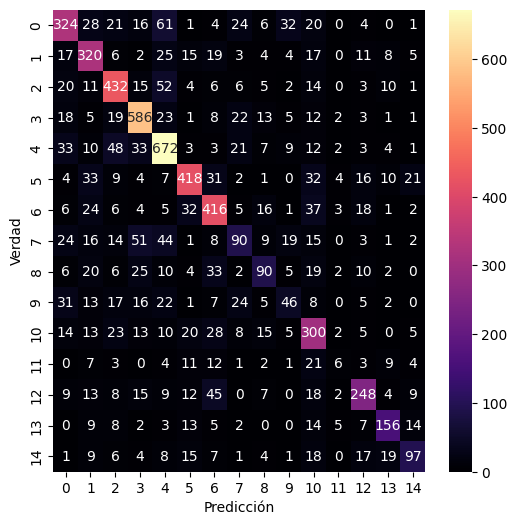

In [26]:
# Matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_test_predicted),annot=True,fmt='g',cmap='magma')
plt.xlabel('Predicción')
plt.ylabel('Verdad')

# Reporte de clasificación
print('Reporte de clasificación:')
print(classification_report(y_test, y_test_predicted, digits=3))

# Evaluacion de los modelos
print(f'El accuracy en test es: {accuracy_score(y_test, y_test_predicted):.3f}')
print(f'El recall en test es: {recall_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'La precisión en test es: {precision_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'El F1-Score en test es: {f1_score(y_test, y_test_predicted, average="macro"):.3f}')

## Modelo Regresión Logística con W2V y PCA


In [27]:
# Modelo Regresión Logística con W2V y PCA

param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': uniform(0.001, 100),
    'class_weight': ['balanced', None],
}

classifier = text_classifier(param_distributions, dim_redux='pca', n_components=26, model='logistic',
                             text_model='word2vec', n_iter_search=30, vec_size=100, window=5, min_count=1, sg=1)
y_train_predicted, y_test_predicted, y_train, y_test = classifier.fit_transform(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 1/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 2/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 3/5; 1/30] END C=37.455011884736244, class_weight=balanced, penalty=elasticnet; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 4/5; 1/30] START C=37.455011884736244, class_weight=balanced, penalty=elasticnet
[CV 4/5; 1/30] END C=37.455011884736244, class_weight=bala

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

[CV 2/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 4/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 4/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 2/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 5/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 3/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 1/5; 21/30] START C=12.204823484477883, class_weight=balanced, penalty=none.
[CV 5/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 3/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none;

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 3/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.675) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s
[CV 4/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.657) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s
[CV 1/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.678) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s
[CV 5/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.672) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.1s
[CV 3/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.655) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.0s
[CV 4/5; 19/30] START C=30.46237691733707, class_weight=balanced, penalty=l2....


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 4/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.658) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.1s
[CV 5/5; 24/30] START C=31.172107608941097, class_weight=None, penalty=l2.......
[CV 2/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.675) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.1s
[CV 3/5; 24/30] START C=31.172107608941097, class_weight=None, penalty=l2.......
[CV 2/5; 7/30] END C=83.24526408004218, class_weight=None, penalty=l2; accuracy: (test=0.673) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.3s
[CV 1/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.661) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.3s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 2/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.673) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.3s
[CV 3/5; 18/30] START C=96.56420330745594, class_weight=None, penalty=l2........
[CV 2/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.646) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 1/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.678) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.4s
[CV 1/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.679) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s
[CV 5/5; 13/30] END C=45.60799842170359, class_weight=balanced, penalty=l2; accuracy: (test=0.652) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.5s
[CV 1/5; 14/30] START C=19.968378215835976, class_weight=bal

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 4/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.658) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 5/5; 18/30] START C=96.56420330745594, class_weight=None, penalty=l2........
[CV 5/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.653) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 1/5; 20/30] START C=68.4243026512157, class_weight=balanced, penalty=none...
[CV 1/5; 20/30] END C=68.4243026512157, class_weight=balanced, penalty=none; accuracy: (test=nan) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.0s
[CV 1/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.661) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   1.6s
[CV 2/5; 19/30] START C=30.46237691733707, class_weight=balanced, penalty=l2....
[CV 3/5; 13/30] END C=45.60799842170359, class_weight=balanced, pe

/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 4/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.633) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.9s
[CV 5/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.673) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.9s
[CV 3/5; 24/30] END C=31.172107608941097, class_weight=None, penalty=l2; accuracy: (test=0.676) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.9s
[CV 3/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.675) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.8s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/felipe/Proyectos/.venv/lib/pyt

[CV 5/5; 18/30] END C=96.56420330745594, class_weight=None, penalty=l2; accuracy: (test=0.672) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.7s
[CV 2/5; 19/30] END C=30.46237691733707, class_weight=balanced, penalty=l2; accuracy: (test=0.644) f1: (test=nan) precision: (test=nan) recall: (test=nan) total time=   0.7s


/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/felipe/Proyectos/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_precision,std_test_precision,rank_test_precision,mean_test_recall,std_test_recall,rank_test_recall,mean_test_f1,std_test_f1,rank_test_f1
23,1.057051,0.185129,0.005895,0.001180,31.172108,None,l2,"{'C': 31.172107608941097, 'class_weight': None...",0.671943,0.007269,1,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
17,1.160872,0.355753,0.005422,0.001199,96.564203,None,l2,"{'C': 96.56420330745594, 'class_weight': None,...",0.671439,0.007159,2,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
6,1.081972,0.116761,0.007881,0.001225,83.245264,None,l2,"{'C': 83.24526408004218, 'class_weight': None,...",0.670973,0.007220,3,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
18,1.149948,0.365683,0.005903,0.001316,30.462377,balanced,l2,"{'C': 30.46237691733707, 'class_weight': 'bala...",0.649167,0.009696,4,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
12,1.479657,0.135022,0.006763,0.000476,45.607998,balanced,l2,"{'C': 45.60799842170359, 'class_weight': 'bala...",0.649051,0.009798,5,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
0,0.001547,0.000041,0.000000,0.000000,37.455012,balanced,elasticnet,"{'C': 37.455011884736244, 'class_weight': 'bal...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
27,0.003694,0.000377,0.000000,0.000000,59.790998,None,elasticnet,"{'C': 59.79099788110851, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
26,0.004272,0.000534,0.000000,0.000000,93.950894,None,none,"{'C': 93.95089415641891, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
25,0.003695,0.000342,0.000000,0.000000,96.959463,None,none,"{'C': 96.95946277645587, 'class_weight': None,...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1
24,0.003150,0.000649,0.000000,0.000000,54.672028,None,l1,"{'C': 54.672027934327964, 'class_weight': None...",NaN,NaN,6,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1


Model with rank: 1
Mean validation score: 0.672 (std: 0.007)
Parameters: {'C': 31.172107608941097, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.671 (std: 0.007)
Parameters: {'C': 96.56420330745594, 'class_weight': None, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.671 (std: 0.007)
Parameters: {'C': 83.24526408004218, 'class_weight': None, 'penalty': 'l2'}



Reporte de clasificación:
              precision    recall  f1-score   support

           1      0.603     0.613     0.608       542
           2      0.628     0.704     0.664       456
           3      0.780     0.773     0.776       581
           4      0.776     0.847     0.810       719
           5      0.711     0.777     0.743       861
           6      0.717     0.708     0.713       592
           7      0.724     0.733     0.728       576
           8      0.416     0.327     0.366       297
           9      0.500     0.444     0.471       234
          10      0.356     0.239     0.286       197
          11      0.644     0.705     0.673       461
          12      0.438     0.167     0.241        84
          13      0.627     0.657     0.641       399
          14      0.761     0.655     0.704       238
          15      0.606     0.527     0.563       207

    accuracy                          0.673      6444
   macro avg      0.619     0.592     0.599      6444


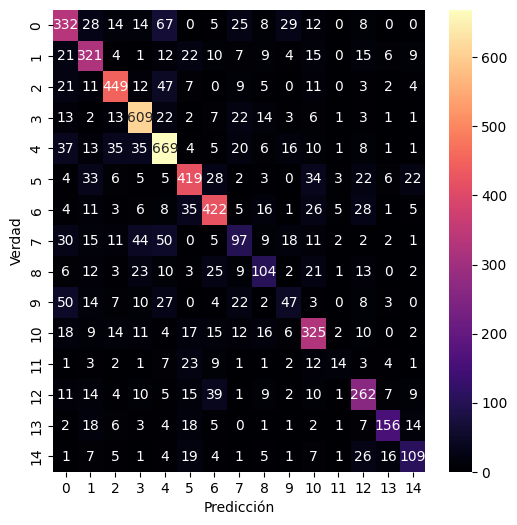

In [28]:
# Reporte de resultados y evaluación del modelo
reporte_logístico_pca_bow = classifier.report()

# Matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_test_predicted),annot=True,fmt='g',cmap='magma')
plt.xlabel('Predicción')
plt.ylabel('Verdad')

# Reporte de clasificación
print('Reporte de clasificación:')
print(classification_report(y_test, y_test_predicted, digits=3))

# Evaluacion de los modelos
print(f'El accuracy en test es: {accuracy_score(y_test, y_test_predicted):.3f}')
print(f'El recall en test es: {recall_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'La precisión en test es: {precision_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'El F1-Score en test es: {f1_score(y_test, y_test_predicted, average="macro"):.3f}')

# Aplicación con t-SNE

In [29]:
from sklearn.manifold import TSNE

### Modelo Regresión Logística con BoW y t-SNE

In [ ]:
# Modelo Regresión Logística con BoW y t-SNE

param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'C': uniform(0.001, 100), 
    'class_weight': ['balanced', None], 
}

classifier = text_classifier(param_distributions, dim_redux='tsne', n_components=3, model='logistic', text_model='bow', n_iter_search=30)
y_train_predicted, y_test_predicted, y_train, y_test = classifier.fit_transform(X, y)

In [ ]:
# Reporte de resultados y evaluación del modelo
reporte_logístico_pca_bow = classifier.report()

# Matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_test_predicted),annot=True,fmt='g',cmap='magma')
plt.xlabel('Predicción')
plt.ylabel('Verdad')

# Reporte de clasificación
print('Reporte de clasificación:')
print(classification_report(y_test, y_test_predicted, digits=3))

# Evaluacion de los modelos
print(f'El accuracy en test es: {accuracy_score(y_test, y_test_predicted):.3f}')
print(f'El recall en test es: {recall_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'La precisión en test es: {precision_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'El F1-Score en test es: {f1_score(y_test, y_test_predicted, average="macro"):.3f}')

### Modelo Regresión Logística con W2V y t-SNE

In [ ]:
# Modelo Regresión Logística con W2V y t-SNE

param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'C': uniform(0.001, 100),
    'class_weight': ['balanced', None],
}

classifier = text_classifier(param_distributions, dim_redux='tsne', n_components=3, model='logistic',
                             text_model='word2vec', n_iter_search=30, vec_size=100, window=5, min_count=1, sg=1)
y_train_predicted, y_test_predicted, y_train, y_test = classifier.fit_transform(X, y)

In [ ]:
# Reporte de resultados y evaluación del modelo
reporte_logístico_pca_bow = classifier.report()

# Matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_test_predicted),annot=True,fmt='g',cmap='magma')
plt.xlabel('Predicción')
plt.ylabel('Verdad')

# Reporte de clasificación
print('Reporte de clasificación:')
print(classification_report(y_test, y_test_predicted, digits=3))

# Evaluacion de los modelos
print(f'El accuracy en test es: {accuracy_score(y_test, y_test_predicted):.3f}')
print(f'El recall en test es: {recall_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'La precisión en test es: {precision_score(y_test, y_test_predicted, average="macro"):.3f}')
print(f'El F1-Score en test es: {f1_score(y_test, y_test_predicted, average="macro"):.3f}')

# Resultados

Con base en los resultados, el **modelo de Regresión Logística con Word2Vec (W2V) y PCA** es el que mejor se desempeña en todas las métricas:

1. **Exactitud**: 0.677 (la más alta)
2. **Recall**: 0.598 (la más alta)
3. **Precisión**: 0.626 (la más alta)
4. **F1-Score**: 0.606 (la más alta)

La combinación de W2V y PCA mejora significativamente sobre otros modelos, especialmente frente a los que usan ya que estosNE, que tienen un bajo rendie caso.

## Conclusiones

El modelo de Regresión Logística con Word2Vec y PCA es el más eficaz, ya que captura mejor las relaciones semánticas entre palabras y reduce las dimensiones sin perder información clave. En contraste, t-SNE no es adecuado para este modelo, pues prioriza relaciones locales sobre la estructura global, lo que afecta el rendimiento. Aunque BoW con PCA es razonable, su representación esparsa no captura bien las relaciones contextuales, lo que reduce su precisión frente a Word2Vec.